In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
# Transformations for MNIST dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Dataloaders for MNIST dataset
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

print("Datasets loaded.")


100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



15.9%

100.0%
100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Datasets loaded.


In [3]:
# CNN Model for Sudoku Digit Recognition
class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [4]:
# Create model and optimizer
model = SudokuCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    train_losses = []  # List to store loss per epoch

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)  # Record the loss for this epoch

        # Print statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    print("Training complete.")
    return train_losses  # Return the list of losses for plotting


        



In [5]:
import matplotlib.pyplot as plt

def plot_train_loss(train_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch [1/5], Loss: 0.1153
Epoch [2/5], Loss: 0.0378
Epoch [3/5], Loss: 0.0244
Epoch [4/5], Loss: 0.0185
Epoch [5/5], Loss: 0.0146
Training complete.


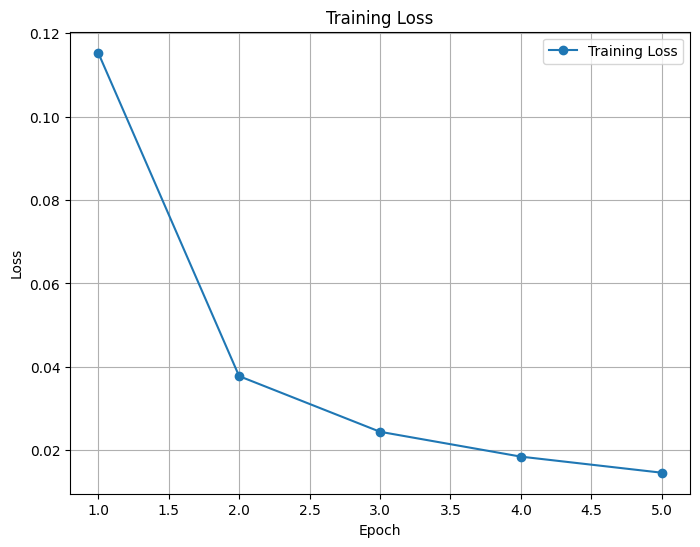

In [6]:
train_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=5)
plot_train_loss(train_losses)

In [48]:
# Load the test images (replace 'your_test_images.npy' with the actual file path)
test_images = np.load (r"C:\Users\Legion 5pro\Downloads\imgs (5).npy")


In [49]:

# Define your function to access a specific cell
def get_cell(matrix, i, j, cell_size=28):
    start_row = i * cell_size
    start_col = j * cell_size
    return matrix[start_row:start_row + cell_size, start_col:start_col + cell_size]


In [50]:
# Modify the preprocess_and_predict function to convert to uint8
def preprocess_and_predict(cell, model, device):
    # Convert the cell to uint8
    cell = (cell * 255).astype(np.uint8)

    # Preprocess the cell
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    cell = transform(cell)
    cell = cell.unsqueeze(0).to(device)

    # Predict the digit
    with torch.no_grad():
        model.eval()
        output = model(cell)
        _, predicted = torch.max(output, 1)
        return predicted.item()


In [51]:
# Example: Extract a cell from the test image
cell_matrix = get_cell(test_images[0], 0, 0)
cell_matrix = cell_matrix / 255

# Preprocess and predict the digit for the cell
predicted_digit = preprocess_and_predict(cell_matrix, model, device)

print("Predicted Digit:", predicted_digit)



Predicted Digit: 2


In [36]:
# Define a function to combine coordinates and predictions
def combine_coordinates(coordinates, predictions):
    for i in range(len(coordinates)):
        coordinates[i].append(predictions[i])
    return coordinates

# Define a function to predict digits and combine them with coordinates
def predict_and_combine(image_matrix, model, device):
    coordinate_array = []
    array = []
    for i in range(9):
        for j in range(9):
            cell_matrix = get_cell(image_matrix, i, j)
            cell_matrix = cell_matrix / 255
            if np.all(cell_matrix == 0):
                pass
            else:
                array.append(cell_matrix)
                coordinate_array.append([i, j])
    predictions = []
    for cell in array:
        predicted_digit = preprocess_and_predict(cell, model, device)
        predictions.append(predicted_digit)
    combined = combine_coordinates(coordinate_array, predictions)
    return combined

# Initialize an empty list to store the results for all test images
predicted_results = []

# Iterate through test images and predict digits and positions
for i in range(len(test_images)):
    image_matrix = test_images[i]
    combined = predict_and_combine(image_matrix, model, device)
    predicted_results.append(combined)


In [46]:
# Display predicted results for one test image
sample_result = predicted_results[0]
print("Length", len(sample_result))
for coord_digit in sample_result:
    print(f"Coordinate: ({coord_digit[0]}, {coord_digit[1]}), Predicted Digit: {coord_digit[2]}")


Length 41
Coordinate: (0, 0), Predicted Digit: 2
Coordinate: (0, 2), Predicted Digit: 7
Coordinate: (0, 4), Predicted Digit: 1
Coordinate: (0, 5), Predicted Digit: 3
Coordinate: (0, 6), Predicted Digit: 4
Coordinate: (1, 0), Predicted Digit: 8
Coordinate: (1, 2), Predicted Digit: 6
Coordinate: (1, 4), Predicted Digit: 4
Coordinate: (1, 5), Predicted Digit: 9
Coordinate: (1, 6), Predicted Digit: 2
Coordinate: (1, 7), Predicted Digit: 3
Coordinate: (1, 8), Predicted Digit: 5
Coordinate: (2, 0), Predicted Digit: 9
Coordinate: (2, 2), Predicted Digit: 3
Coordinate: (2, 5), Predicted Digit: 6
Coordinate: (2, 6), Predicted Digit: 8
Coordinate: (3, 1), Predicted Digit: 9
Coordinate: (3, 4), Predicted Digit: 5
Coordinate: (3, 7), Predicted Digit: 2
Coordinate: (4, 0), Predicted Digit: 1
Coordinate: (4, 2), Predicted Digit: 8
Coordinate: (4, 3), Predicted Digit: 9
Coordinate: (4, 4), Predicted Digit: 7
Coordinate: (4, 6), Predicted Digit: 5
Coordinate: (4, 7), Predicted Digit: 6
Coordinate: (5,

In [53]:
import csv

# Define the file path for the submission file
submission_file_path = r"C:\Users\Legion 5pro\Desktop\SudokuPuzzle\sudoku_recognition\Output_Task1.csv.csv"

# Initialize the CSV data as a list
csv_data = [["id", "value"]]

# Define the maximum image ID (assuming 10000 test images)
max_image_id = 9999

# Iterate through all possible coordinates in the 9x9 grid
for image_id in range(max_image_id + 1):
    for i in range(9):
        for j in range(9):
            # Convert coordinates to the required format (e.g., 0_00)
            coord_str = f"{image_id}_{i}{j}"
            # Set the default value to 0
            digit = 0
            # If the result is available for this coordinate, update the digit
            if image_id < len(predicted_results):
                result = predicted_results[image_id]
                for item in result:
                    coord_result = item[:2]
                    digit_result = item[2]
                    if coord_result == [i, j]:
                        digit = digit_result
                        break
            # Append the data to the CSV list
            csv_data.append([coord_str, digit])

# Write the CSV data to a file
with open(submission_file_path, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(csv_data)

print(f"Submission file '{submission_file_path}' generated successfully.")

Submission file 'C:\Users\Legion 5pro\Desktop\SudokuPuzzle\sudoku_recognition\Train_Output_Task1_submission.csv' generated successfully.
